<a href="https://colab.research.google.com/github/calebweldon/BlackjackAI/blob/main/BlackjackAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blackjack AI
****
This project utilizes Tensorflow, Keras, and OpenAI Gym to develop a functional AI model that learns a strategy almost 90% similar to the statistically optimal blackjack strategy. <br><br>

The rules for the blackjack game are:
* One deck
* Dealer stands on soft 17
* Blackjack pays 3:2
* Only allowed to hit or stand (no doubling or spliiting)

In [ ]:
# Install packages
!pip install keras-rl2
!pip install tensorflow
!pip install gym==0.25.1

In [ ]:
# Import packages
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import History
from keras.regularizers import L2
from rl.agents import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [ ]:
# Set up blackjack environemnt
env = gym.make('Blackjack-v1', natural = True)
actions = env.action_space.n
states = 3

In [ ]:
# Build model
def buildModel(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape =(1,3)))
    model.add(Dense(8, activation='relu', kernel_regularizer=L2(0.001)))
    model.add(Dense(12, activation='relu', kernel_regularizer=L2(0.001)))
    model.add(Dense(actions, activation='linear'))
    return model

model = buildModel(states, actions)

In [ ]:
# Build agent with Keras RL
def buildAgent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max = 1, value_min = .1, value_test = .2, nb_steps=20000)
    memory = SequentialMemory(limit=30000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, enable_dueling_network = True, dueling_type = 'avg', nb_actions = actions, nb_steps_warmup=1000)
    return dqn

In [ ]:
# Train model
dqn = buildAgent(model, actions)
dqn.compile(optimizer=Adam(learning_rate=1e-4))
history = History()
history = dqn.fit(env, nb_steps=30000, visualize=False, verbose=1)

Training for 30001 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 229s 23ms/step - reward: -0.2519
7828 episodes - episode_reward: -0.322 [-1.000, 1.000] - loss: 0.980 - mean_q: -0.174 - mean_eps: 0.753

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 233s 23ms/step - reward: -0.1468
7761 episodes - episode_reward: -0.189 [-1.000, 1.000] - loss: 0.325 - mean_q: -0.057 - mean_eps: 0.325

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 210s 21ms/step - reward: -0.0694
6913 episodes - episode_reward: -0.100 [-1.000, 1.000] - loss: 0.290 - mean_q: -0.050 - mean_eps: 0.100

Interval 4 (30000 steps performed)
    1/10000 [..............................] - ETA: 2:44 - reward: 0.0000e+00done, took 673.155 seconds


In [ ]:
# Save model
model.save_weights('model_v4_weights.h5')
model.save('model_v4.h5')

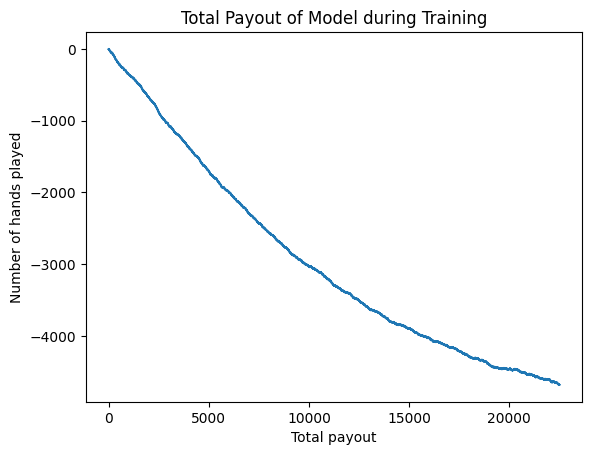

In [ ]:
# Track payout throughout training
total = []
score = 0
for index, reward in enumerate(history.history['episode_reward']):
        score += reward
        total.append(score)

# Plot
plt.plot(range(len(total)), total)
plt.xlabel('Total payout')
plt.ylabel('Number of hands played')
plt.title('Total Payout of Model during Training')
plt.show()

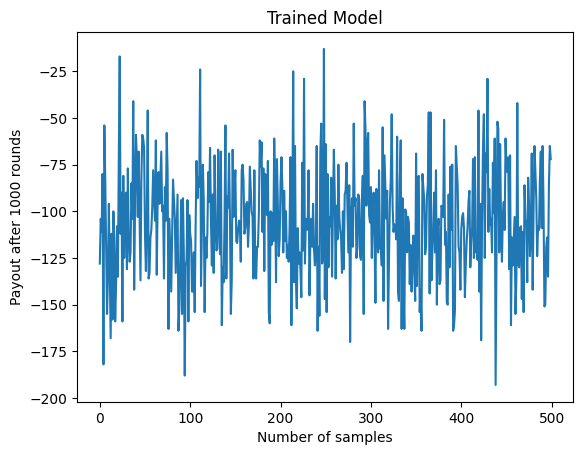

Average payout after 1000 rounds is -106.034


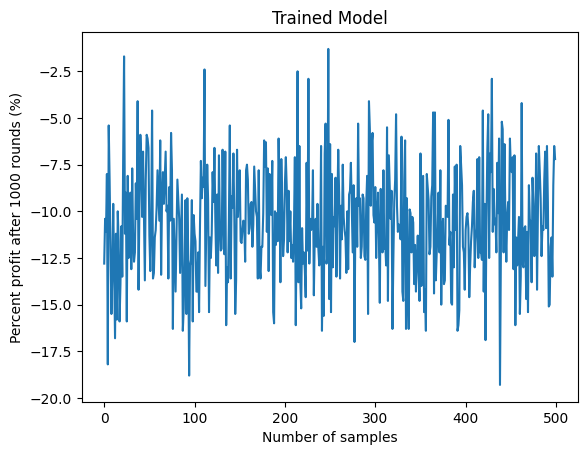

Average percent profit after 1000 rounds is -10.6034%
[((4, 1, False), 1), ((4, 2, False), 1), ((4, 3, False), 1), ((4, 4, False), 1), ((4, 5, False), 1), ((4, 6, False), 1), ((4, 7, False), 1), ((4, 8, False), 1), ((4, 9, False), 1), ((4, 10, False), 1), ((5, 1, False), 1), ((5, 2, False), 1), ((5, 3, False), 1), ((5, 4, False), 1), ((5, 5, False), 1), ((5, 6, False), 1), ((5, 7, False), 1), ((5, 8, False), 1), ((5, 9, False), 1), ((5, 10, False), 1), ((6, 1, False), 1), ((6, 2, False), 1), ((6, 3, False), 1), ((6, 4, False), 1), ((6, 5, False), 1), ((6, 6, False), 1), ((6, 7, False), 1), ((6, 8, False), 1), ((6, 9, False), 1), ((6, 10, False), 1), ((7, 1, False), 1), ((7, 2, False), 1), ((7, 3, False), 1), ((7, 4, False), 1), ((7, 5, False), 1), ((7, 6, False), 1), ((7, 7, False), 1), ((7, 8, False), 1), ((7, 9, False), 1), ((7, 10, False), 1), ((8, 1, False), 1), ((8, 2, False), 1), ((8, 3, False), 1), ((8, 4, False), 1), ((8, 5, False), 1), ((8, 6, False), 1), ((8, 7, False), 1), (

In [ ]:
# Test AI on a batch of 500,000 blackjack hands

# define variables
num_rounds = 1000
num_samples = 500

average_payouts = []
observation_actions = {}
percents = []
wins = 0
losses = 0
ties = 0
blackjacks = 0
hits = 0
stands = 0

# run simulation
for sample in range(num_samples):
    round = 1
    total_payout = 0
    percent = 0

    while round <= num_rounds:
        observation = env.reset()
        # Take random action
        action = dqn.forward(observation)

        if observation in observation_actions:
          # Increment the count for the current action
          observation_actions[observation][action] = observation_actions[observation].get(action, 0) + 1
        else:
          # Add the observation to the dictionary with the initial count for the action
          observation_actions[observation] = {action: 1}

        obs, payout, is_done, _ = env.step(action)

        if action == 1:
          hits += 1
        else:
          stands += 1

        if is_done:
            total_payout += payout
            percent = total_payout/10

            if payout == 1:
              wins += 1
            elif payout == -1:
              losses += 1
            elif payout == 0:
              if obs[0] == 21:
                blackjacks += 1
              else:
                ties += 1

            # Environment deals new cards to player and dealer
            env.reset()
            round += 1
    average_payouts.append(total_payout)
    percents.append(percent)

# Plot
plt.plot(average_payouts)
plt.xlabel('Number of samples')
plt.ylabel('Payout after 1000 rounds')
plt.title('Trained Model')
plt.show()
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

plt.plot(percents)
plt.xlabel('Number of samples')
plt.ylabel('Percent profit after 1000 rounds (%)')
plt.title('Trained Model')
plt.show()
print ("Average percent profit after {} rounds is {}%".format(num_rounds, sum(percents)/num_samples))

# Calculate most used actions
most_used_actions = {}

for observation, actions in observation_actions.items():
    most_used_action = max(actions, key=actions.get)
    most_used_actions[observation] = most_used_action

# Print the most used actions
most_used_sorted = sorted(most_used_actions.items(), key=lambda x: (x[0][0], x[0][1], x[0][2]))
print(most_used_sorted)

In [ ]:
# Print statistics
print(f"Hits: {hits}, Stands: {stands}")
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}, Blackjacks: {blackjacks}")

Hits: 409472, Stands: 418636

Wins: 204462, Losses: 257479, Ties: 36352, Blackjacks: 1707


# Comparison against other three other strategies
****
1) Random strategy: 50/50 chance of hitting or standing

2) Naive Strtegy: stands on hands of value 17 or over

3) Ideal Strategy: optimal strategy that will play the statistically optimal move every time

In [ ]:
# Define function to test strategies
def testStrategy(strategy, isRandom, isNaive):
  env.reset()

  num_rounds = 1000
  num_samples = 500

  percents=[]
  wins = 0
  losses = 0
  ties = 0
  blackjacks = 0
  hits = 0
  stands = 0

  for sample in range(num_samples):
      round = 1
      total_payout = 0

      while round <= num_rounds:
          if not isRandom:
            observation = env.reset()
          action = env.action_space.sample() if isRandom else strategy(observation)
          obs, payout, is_done, _ = env.step(action)

          if action == 1:
              hits += 1
          else:
            stands += 1

          if is_done:
              total_payout += payout
              percent = total_payout/10

              if payout == 1:
                wins += 1
              elif payout == -1:
                losses += 1
              elif payout == 0:
                if obs[0] == 21:
                  blackjacks += 1
                else:
                  ties += 1

              env.reset()
              round += 1
      percents.append(percent)

  # Plot
  plt.plot(percents)
  plt.xlabel('Number of samples')
  plt.ylabel('Percent profit after 1000 rounds (%)')
  plt.title('Random Strategy' if isRandom else 'Naive Strategy' if isNaive else 'Ideal Strategy')
  plt.show()
  print ("Average percent profit after {} rounds is {}%".format(num_rounds, sum(percents)/num_samples))

  # Print statistics
  print(f"\nHits: {hits}, Stands: {stands}")
  print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}, Blackjacks: {blackjacks}")

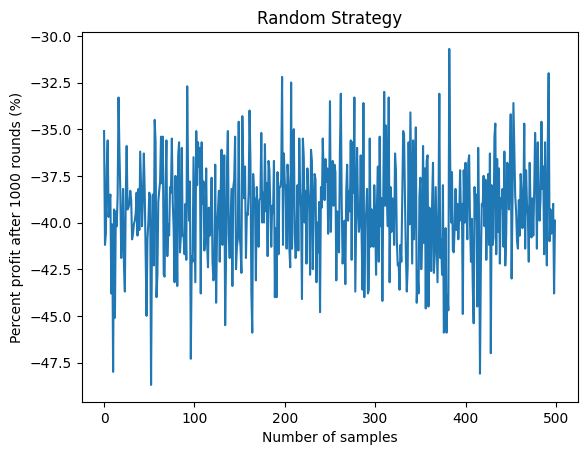

Average percent profit after 1000 rounds is -39.36560000000005%

Hits: 344582, Stands: 343679
Wins: 141326, Losses: 338154, Ties: 18222, Blackjacks: 2298


In [ ]:
# Test random strategy on a batch of 500,000 blackjack hands
testStrategy(None, True, False)

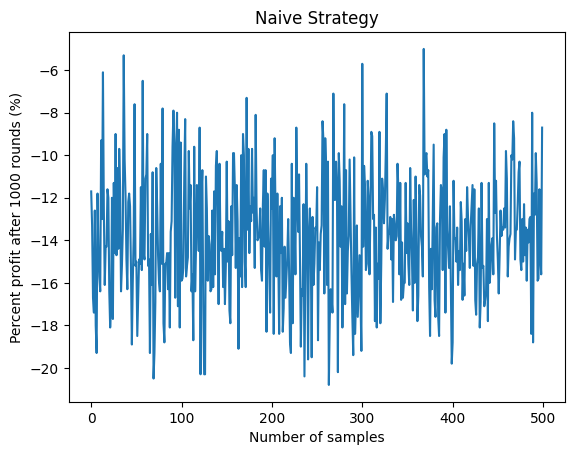

Average percent profit after 1000 rounds is -13.808999999999996%

Hits: 622832, Stands: 333868
Wins: 191999, Losses: 261044, Ties: 44845, Blackjacks: 2112


In [ ]:
# Test naive strategy (stand on hands 17 or greater) on a batch of 500,000 blackjack hands

# Naive strategy
def naiveStrategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is >= 17, hit (action 1) otherwise
    return 0 if score >= 17 else 1

# Run simulation
testStrategy(naiveStrategy, False, True)

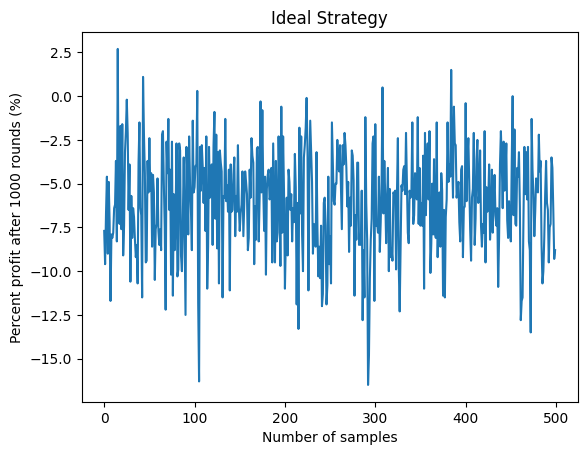

Average percent profit after 1000 rounds is -6.0380000000000065%

Hits: 453934, Stands: 406563
Wins: 214921, Losses: 245111, Ties: 38020, Blackjacks: 1948


In [ ]:
# Test ideal strategy on a batch of 500,000 blackjack hands

# Ideal strategy
def idealStrategy(observation):

    # Chart based from https://www.beatingbonuses.com/bjstrategy.php?decks2=1&h17=
    # stand&doubleon2=910to11&peek2=off&surrender2=no&charlie2=no&splitA=0&split4=0&resplits2=0&shuffle=0&bj=3to2&opt2=1&btn2=Generate+Strategy
    # 1 Deck, Dealer Stands on Soft 17, Dealer Does Not Peek for BJ

    player_hand, dealer_upcard, usable_ace = observation
    stand = 0
    hit = 1

    if usable_ace:
        if 12 <= player_hand <= 17:
            action = hit
        elif player_hand in [19,20,21]:
            action = stand
        elif player_hand == 18:
            if dealer_upcard in [2, 3, 4, 5, 6, 7, 8, 11]:
                action = stand
            else:
                action = hit

    else:
        if 4 <= player_hand <= 11:
            action = hit
        elif player_hand == 12:
            if dealer_upcard in [2,3,7,8,9,10,11]:
                action = hit
            else:
                action = stand
        elif player_hand in [13,14,15,16]:
            if dealer_upcard in [2,3,4,5,6]:
                action = stand
            else:
                action = hit
        elif player_hand in [17,18,19,20,21]:
            action = stand

    return action

# Check strategy is functioning properly
assert idealStrategy((15, 2, 0)) == 0
assert idealStrategy((15, 11, 0)) == 1
assert idealStrategy((18, 4, 1)) == 0
assert idealStrategy((18, 9, 1)) == 1

# Run simulation
testStrategy(idealStrategy, False, False)

# Results

****
*Note: With the given game rules and inability to double or split, the house will always be favored and no strategy was able to be profitable*<br><br>

**Profitability performance**

1) Ideal Strategy: -6.04% profit

2) AI Model: -10.64% profit

3) Naive Strategy: -13.81% profit

4) Random Strategy: -39.37% profit <br><br>


**Hit Chart**

Ideal Strategy:
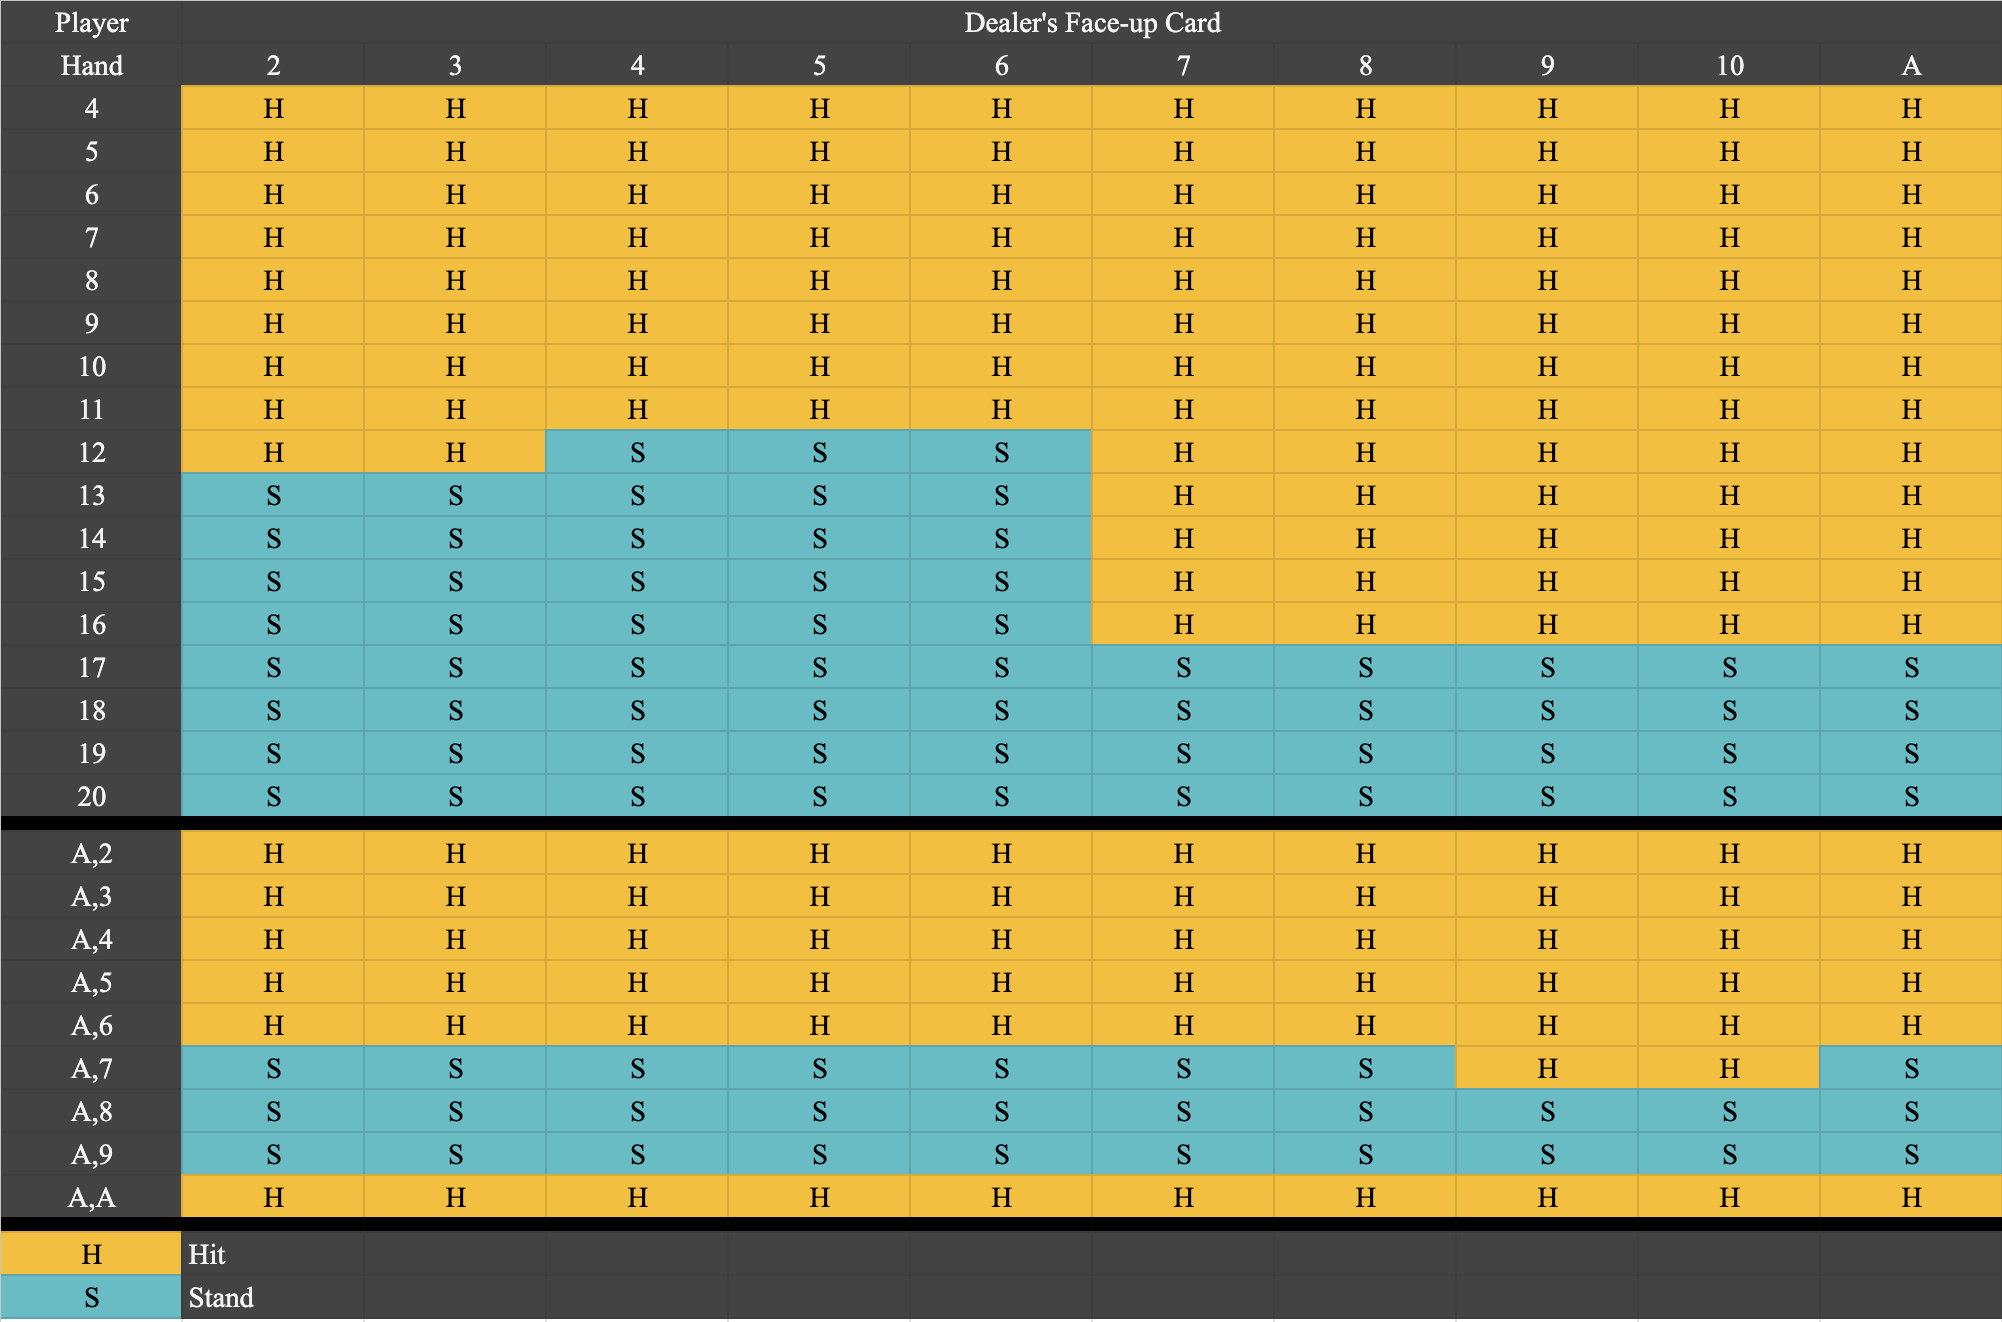 <br><br>

AI Model:
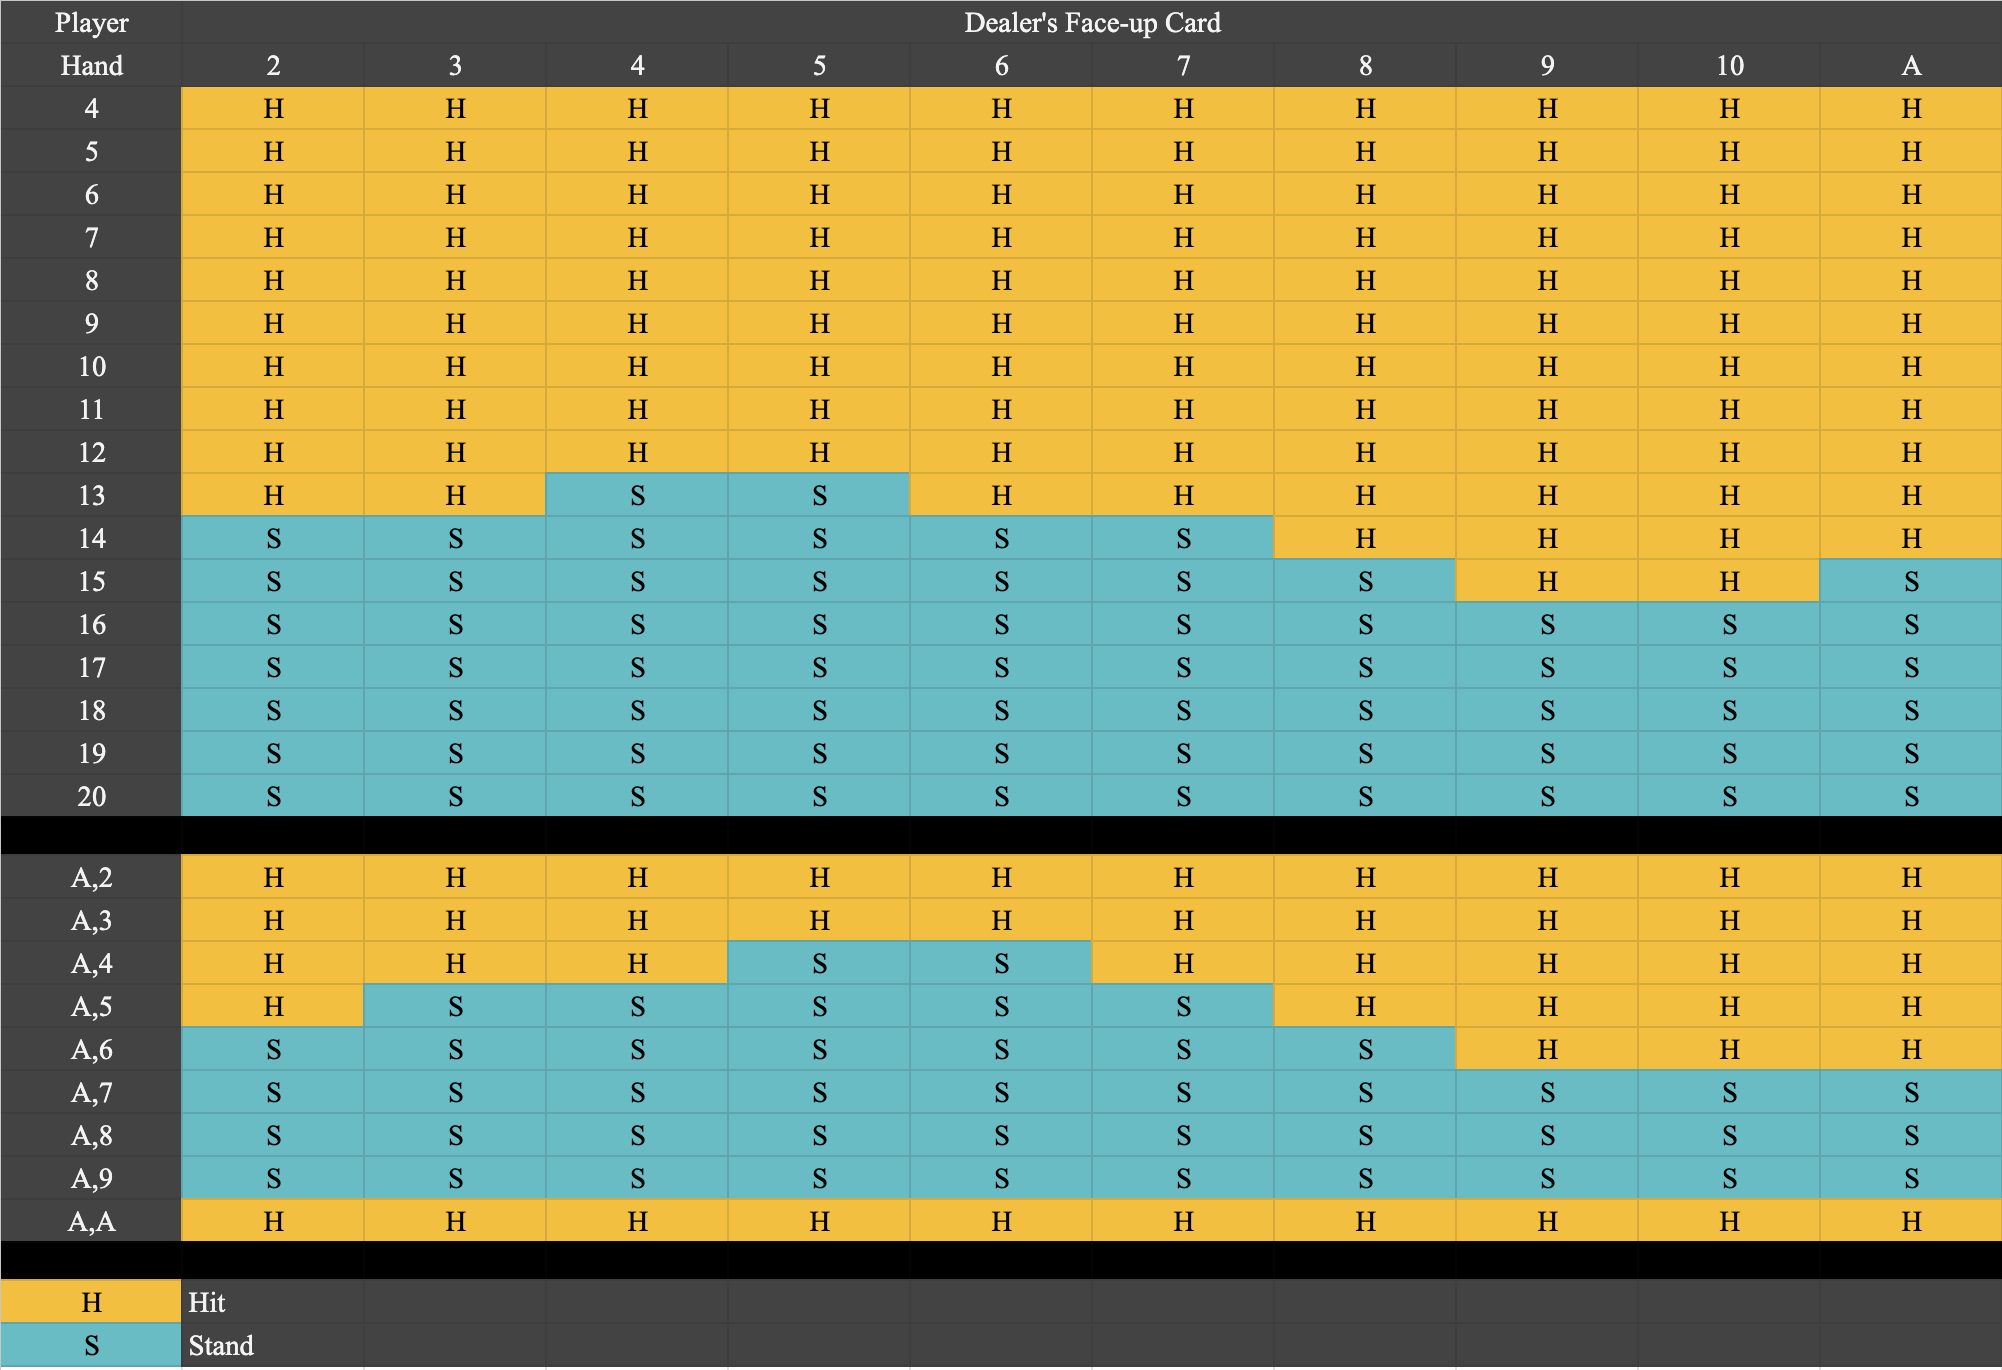 <br><br>

Comparison:
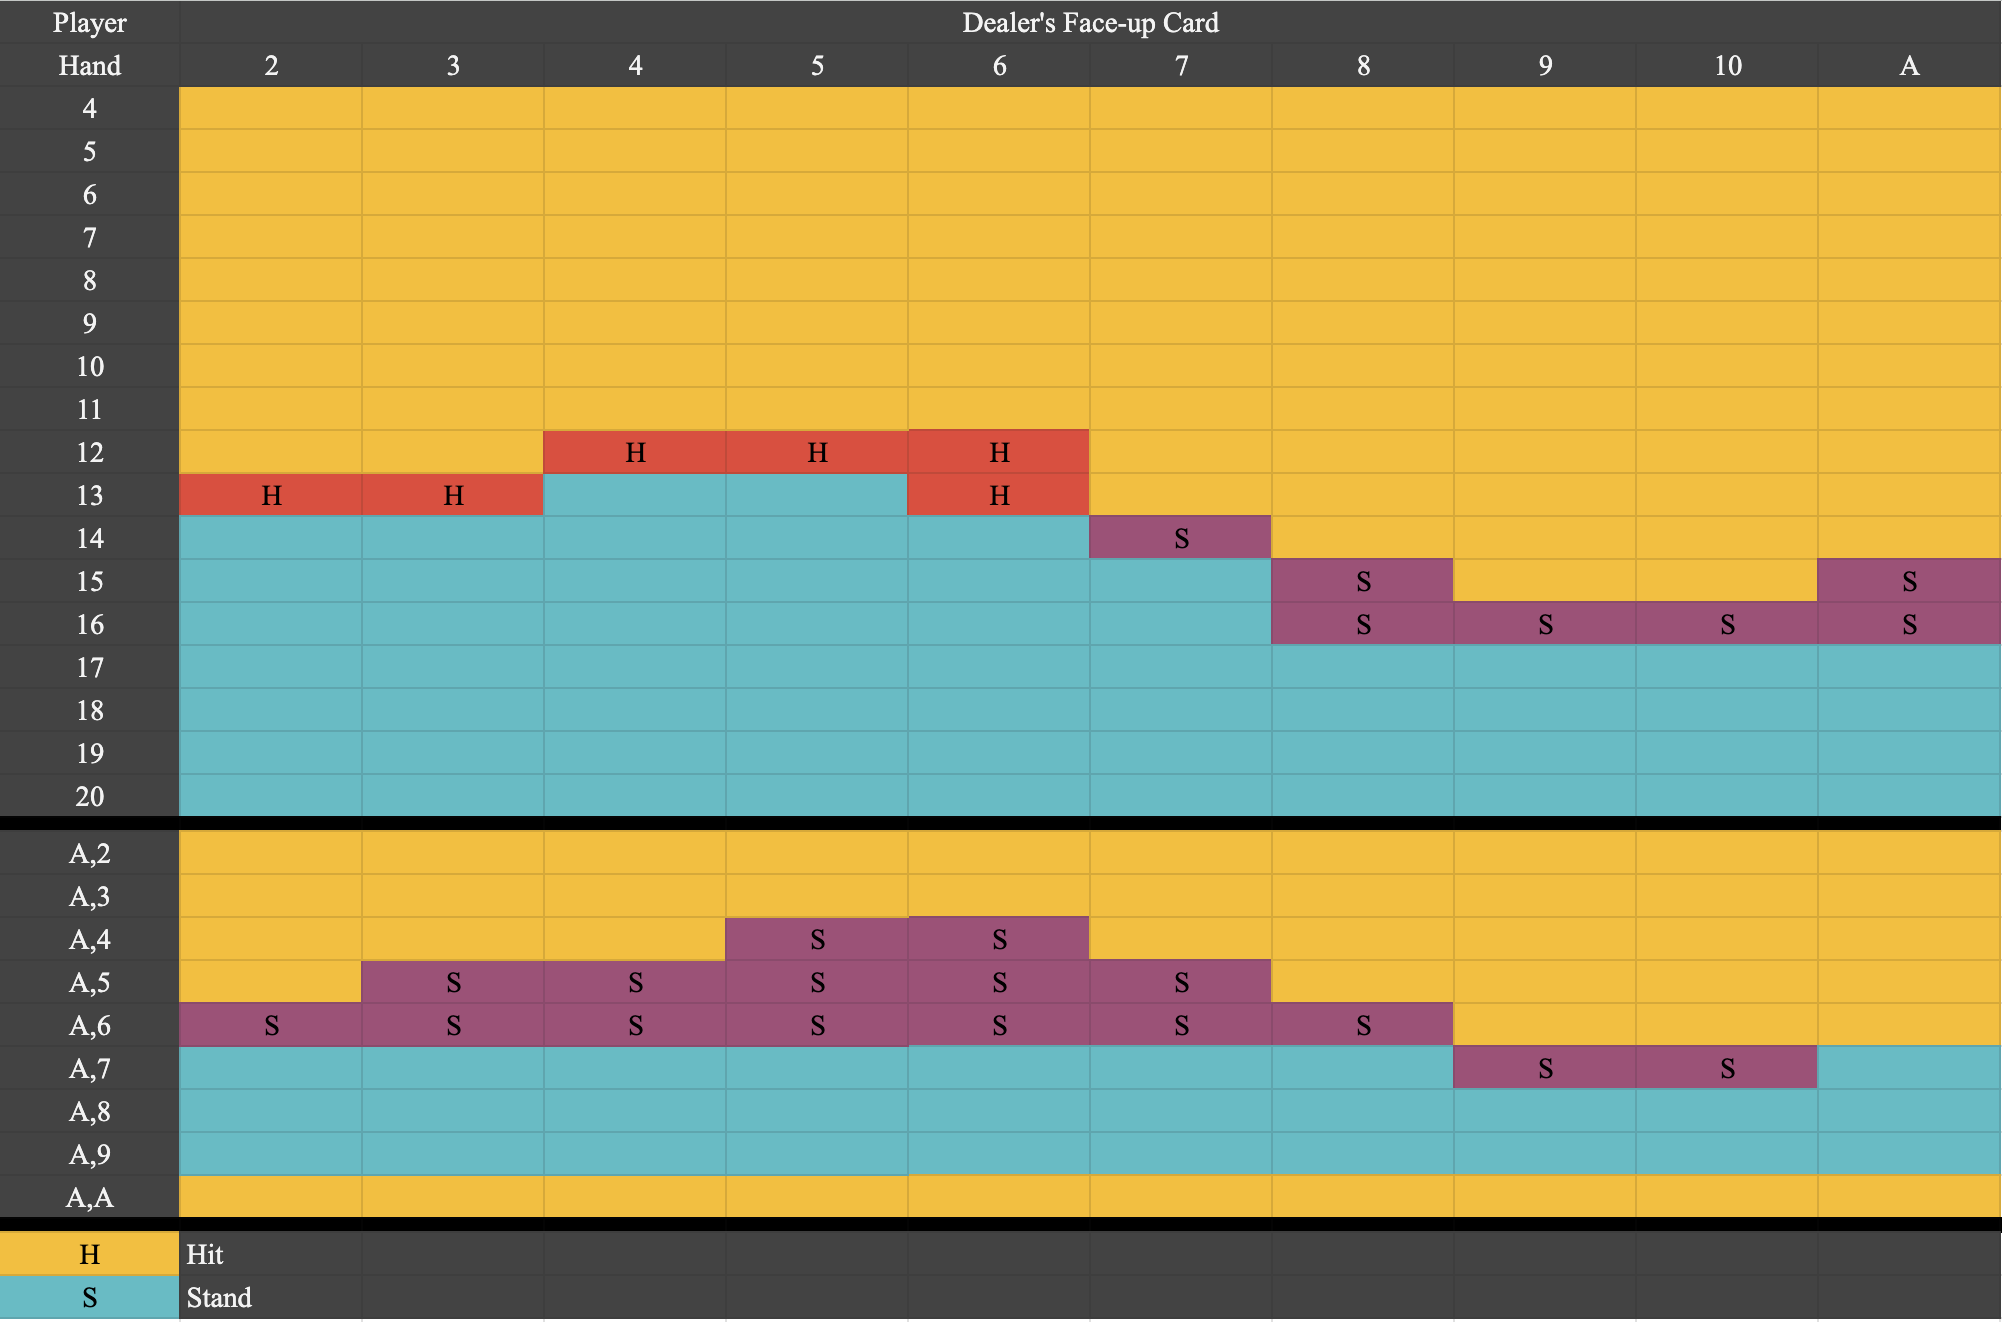 <br><br>

**Conclusion**

The AI model had a hit chart 88.85% accurate compared to the ideal strategy hit chart. It had the most innacuracy when dealt an ace. For profitability, the model performed 3.17% better than the naive strategy and 4.6% worse than the ideal strategy. Overall, the model was able to improve through training and develop a strategy almost 90% similar to the optimal strategy. However, I would like to optimize my model further to increase its efficacy.

